In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

C:\Users\tomco\AppData\Local\Temp\ipykernel_31412\975059756.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<h4>Load the data in pandas, and inspect its features</h4>

In [2]:
df = pd.read_csv("Household energy bill data.csv")

<b>Always check for duplicates and missing data at first</b>

<Axes: >

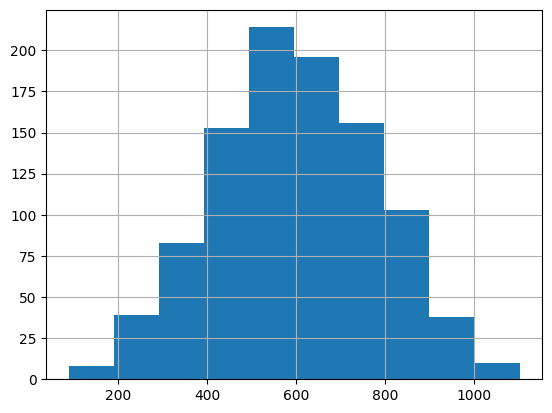

In [3]:
# The data appears to follow a normal distribution (at least for the electricity cost)
df["amount_paid"].hist()

<b>Typically the data processing phase is a lot longer, but since this is a synthetic dataset it does not need much processing,</b>

<b>therefore the data seems to be good to go at this point!</b>

In [4]:
df.columns

Index(['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban', 'amount_paid'],
      dtype='object')

<h3>Scaling the values with a minmaxscaler, so that we get scaled error metrics later</h3>
Instead of having absolute dollars as error, we get a relative error (close to a %)

In [ ]:
# select the variables that are going to scaled (continuous variables only)
num_vars = ['housearea', 'ave_monthly_income']

# MinMaxScaler is the basic scaler. basically: 0 means lowest value in the column
# 1 means highest value in the column. all values will be decimals between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler_with_price = MinMaxScaler()
df[num_vars] = scaler_with_price.fit_transform(df[num_vars])

In [5]:
# if you have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)
X = df[['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban']]

# have only the target variable here (dependent variable)
y = df['amount_paid']

In [10]:
# a nice trick to get all 6 variables for our neural network
# first split 70% for training data, and save the last 30% for temporary variables
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# then split again the temporary variables by 50% (so if it was 30% originally => now it's
# 15%/15% (because 30% * 50% = 15%))

# so after this, we have 70% for training, 15% testing, and 15% validation
# => 100% in total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [11]:
df.describe()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.962000,4.897000,794.703420,0.376000,0.798000,0.477000,24684.986550,1.078000,0.608000,600.396359
std,1.030348,2.007591,147.771736,0.484622,0.401693,0.499721,9678.228224,0.934232,0.488441,181.406210
min,-1.000000,-1.000000,244.400000,0.000000,0.000000,0.000000,-1576.440000,0.000000,0.000000,87.851850
25%,1.000000,4.000000,691.037500,0.000000,1.000000,0.000000,18036.762500,0.000000,0.000000,475.065141
50%,2.000000,5.000000,789.970000,0.000000,1.000000,0.000000,24742.575000,1.000000,1.000000,598.331726
75%,3.000000,6.000000,892.955000,1.000000,1.000000,1.000000,31402.357500,2.000000,1.000000,729.930489
max,5.000000,11.000000,1189.120000,1.000000,1.000000,1.000000,56531.080000,4.000000,1.000000,1102.994109


In [66]:
# 9 variables in this case for training
training_variable_amount = len(X.columns)

# Use ModelCheckpoint to always save the best version of the model
# from anywhere from the model's taining history (not just the last epoch)
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# Have all callbacks in a list,
# in this case there's just one
callback_list = [mc]

# create the structure of our neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(training_variable_amount,)),
        layers.Dense(12, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),

        # Adding a Dropout-layer, often helps to reduce the validation loss (less overfitting)
        layers.Dropout(0.1),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ]
)

# compile the neural network, use adam (most common one) as the optimizer
# and mean square error (mse) for the loss function (most common for regression problems)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='mse')

# show a quick recap of our structure
model.summary()

# start training 
model.fit(x=X_train, y=y_train, epochs=1500, validation_data=(X_val, y_val), callbacks=callback_list)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Bat  (None, 9)                 36        
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 16)                160       
                                                                 
 dense_42 (Dense)            (None, 8)                 136       
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_43 (Dense)            (None, 4)                 36        
                                                                 
 dense_44 (Dense)            (None, 1)                 5         
                                                     

<h4>Training metrics, comparing losses</h4>

<Axes: >

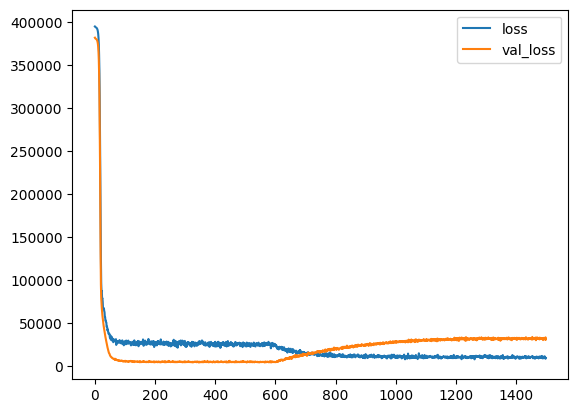

In [67]:
# let's see if our models overfits
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [64]:
# After plotting the history
# load the best version of the model from the file
from keras.models import load_model
model = load_model("best_model.keras")

In [65]:
# these should be as relatively close to each other as possible
# in this case, ~4600 to 4450 is quite close
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
5375.2880859375

Train data evaluation:
4910.4951171875


In [46]:
# we need to calculate test predictions based on the TEST DATA SET
# for metrics that follow
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

5/5 [==============================] - 0s 4ms/step


,Test True Y,Model Predictions
0,529.752567,590.230469
1,725.970313,692.784058
2,742.379815,801.105225
3,675.483254,687.304077
4,485.738650,469.864288
...,...,...
145,439.728088,448.581757
146,800.416867,785.401367
147,562.955168,586.860229
148,473.820453,570.178589


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

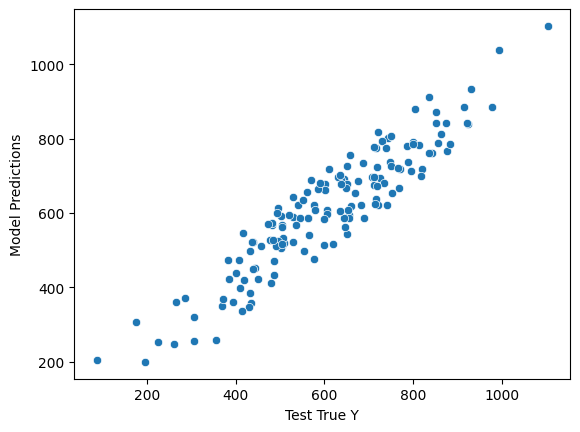

In [47]:
# compare the predictions to real values
# if these follow a diagonal line => they correlate well
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [48]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
55.84 $

MSE
4312.73 $^2

RMSE:
65.67 $

R-squared:
0.86

Explained variance score:
0.87


C:\Users\tomco\AppData\Local\Temp\ipykernel_17108\1775748582.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


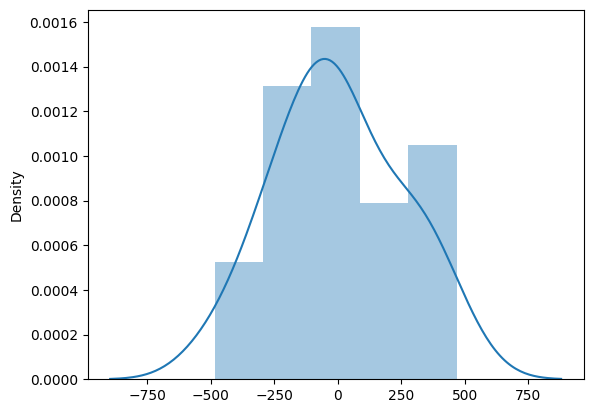

In [49]:
# residual histogram, does our model also follow 
# a normal distribution
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [19]:
df.head(3)

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157


In [50]:
# let's try with some new imaginary data
# one imaginary household without the price data (because that's what we will predict)
# modify this as needed regarding your own dataset
tester_row = {
    'num_rooms': 4, 
    'num_people': 3, 
    'housearea': 829, 
    'is_ac': 1, 
    'is_tv': 1, 
    'is_flat': 0,
    'ave_monthly_income': 18500, 
    'num_children': 1,
    'is_urban': 0,
    'amount_paid': 0,
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

# finally get the prediction from our model
# based on the imaginary values above
result = model.predict(tester_row)[0]

print()
print(f"Estimated electricity bill for this household $:")
print(f"{round(float(result), 2)}")
print("----------------")